## FontStyleGAN


### Setup

In [1]:
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import torch

from util import show_grayscale_image
%matplotlib inline

USE_GPU = True

data_type = torch.FloatTensor

if USE_GPU and torch.cuda.is_available():
    data_type = torch.cuda.FloatTensor

print(torch.cuda.memory_allocated())

glyph_size = (16, 16)
glyphs_per_image = 26

0


In [2]:
from data.font_dataset import FontDataset
from data.font_data_loader import FontDataLoader

dataset = FontDataset('./datasets/fonts/', glyph_size=glyph_size, glyphs_per_image=glyphs_per_image)
print(dataset[0].shape)

# Show what a normalized image looks like.
show_grayscale_image(dataset[0])

torch.Size([1, 16, 416])


torch.Size([1, 16, 16])


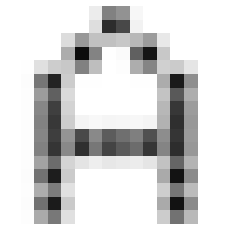

In [3]:
single_image = dataset[0][:,:,0:glyph_size[1]]
print(single_image.shape)

# Sample a specific image
show_grayscale_image(single_image)

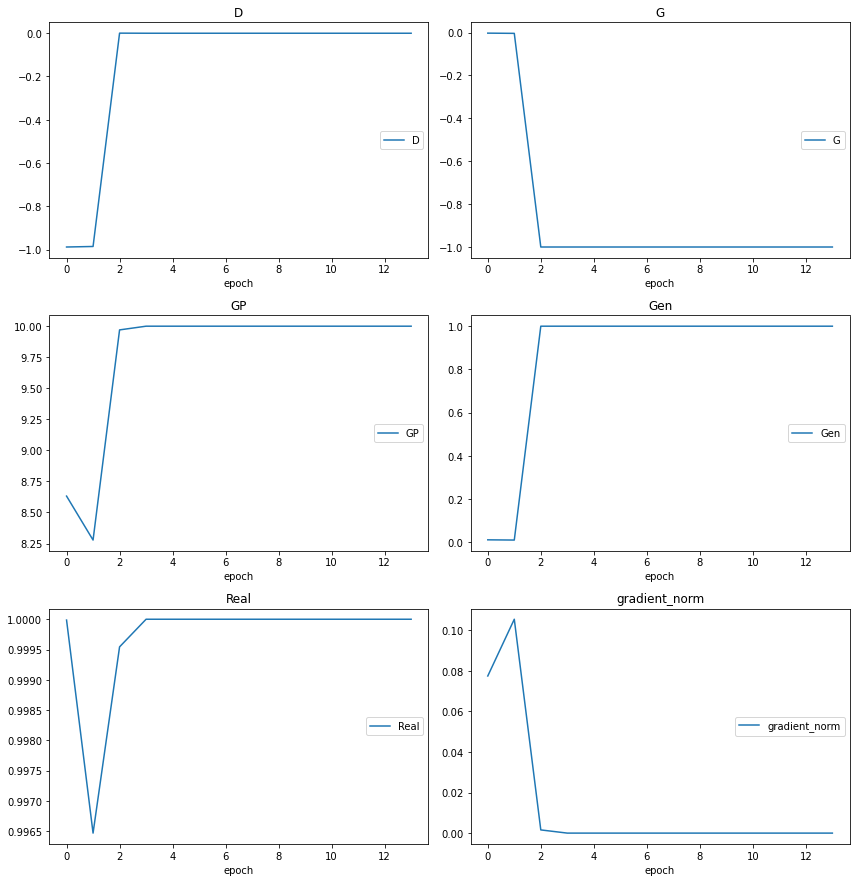

D
	D                	 (min:   -0.988, max:    0.000, cur:    0.000)
G
	G                	 (min:   -1.000, max:   -0.002, cur:   -1.000)
GP
	GP               	 (min:    8.278, max:   10.000, cur:   10.000)
Gen
	Gen              	 (min:    0.011, max:    1.000, cur:    1.000)
Real
	Real             	 (min:    0.996, max:    1.000, cur:    1.000)
gradient_norm
	gradient_norm    	 (min:    0.000, max:    0.105, cur:    0.000)


In [ ]:
from models.models import build_font_shape_generator, build_font_shape_discriminator, get_optimizer, initialize_weights
from train import train

print(torch.cuda.memory_allocated())

G = build_font_shape_generator(glyph_size=glyph_size, glyph_count=glyphs_per_image, dimension=16)
G_optimizer = get_optimizer(G)
G.apply(initialize_weights)

D = build_font_shape_discriminator(image_size=(glyph_size[0], glyph_size[1] * glyphs_per_image))
D_optimizer = get_optimizer(D)
D.apply(initialize_weights)

batch_size = 64
epoch_count = 100

data_loader = FontDataLoader(dataset, batch_size=batch_size)

if USE_GPU and torch.cuda.is_available():
    G.cuda()
    D.cuda()
    
train(D, G, D_optimizer, G_optimizer, batch_size, epoch_count, data_loader, data_type, glyph_size, glyphs_per_image)

In [ ]:
for data in data_loader:
    # For now, only use A
    generated = G(data[0:1,:,:,0:64].type(data_type))
    
    # Flatten the generated shape
    generated_shape = generated.shape
    generated = generated.reshape(generated_shape[0], generated_shape[1], 64, 2048)
    print(generated.shape)
    
    # Extract only letters A-Z (ignore blank space) (64 x 26 = 1664)
#     generated = generated[:, :, :, 0:1664]
    
    plt.imshow(transforms.Compose([
        transforms.ToPILImage('L')
    ])(generated[0].cpu()))
    break
    